### Imports

In [127]:
### basics
# import wandb
import torch
import pandas as pd
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

### Data Manager
import utils.enums as enums
import utils.data_manager as data_manager

### torch modules
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
### data spliting
from sklearn.model_selection import train_test_split
### Plots
import plotly.graph_objects as go
import seaborn as sns


### Helpers

In [128]:
def plat_predictions(result: pd.DataFrame):
    fig = go.Figure()
    fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                        mode='lines',
                        name='Train prediction')))
    fig.add_trace(go.Scatter(x=result.index, y=result[1],
                        mode='lines',
                        name='Test prediction'))
    fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                        mode='lines',
                        name='Actual Value')))

    fig.update_layout(
        xaxis=dict(
            showline=True,
            showgrid=True,
            showticklabels=False,
            linecolor='white',
            linewidth=2
        ),
        yaxis=dict(
            title_text='Close (EUR)',
        ),
        showlegend=True,
        template = 'plotly_dark'
    )

    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                xanchor='left', yanchor='bottom',
                                text='Results (GRU)',
                                font=dict(family='Rockwell',
                                            size=26,
                                            color='white'),
                                showarrow=False))
    fig.update_layout(annotations=annotations)

    fig.show()

### Configuration

In [129]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)

progres_print_rate = 10

config = {
  'batch_size': 1000,
  'epochs': 100,
  'learning_rate': 0.00001,
  'pin_memory': False,
  'num_workers': 0,
  'model_path': './data/model/',
}

cuda


### DATA Loading

In [130]:
pair = "ETH/EUR"
data = data_manager.get_stored_prices(pair=pair.replace('/','')).tail(100)
data.head()

,time,open,high,low,close,volume,count,dateTime
221136,1648681200,3034.74,3038.79,3033.85,3037.97,3.212415,28,2022-03-31 01:00:00
221137,1648682100,3037.97,3038.68,3032.05,3037.45,2.127931,50,2022-03-31 01:15:00
221138,1648683000,3037.15,3040.62,3036.48,3036.71,1.235313,48,2022-03-31 01:30:00
221139,1648683900,3036.48,3038.16,3027.45,3032.63,8.065335,66,2022-03-31 01:45:00
221140,1648684800,3033.55,3041.12,3028.49,3040.33,7.610989,87,2022-03-31 02:00:00


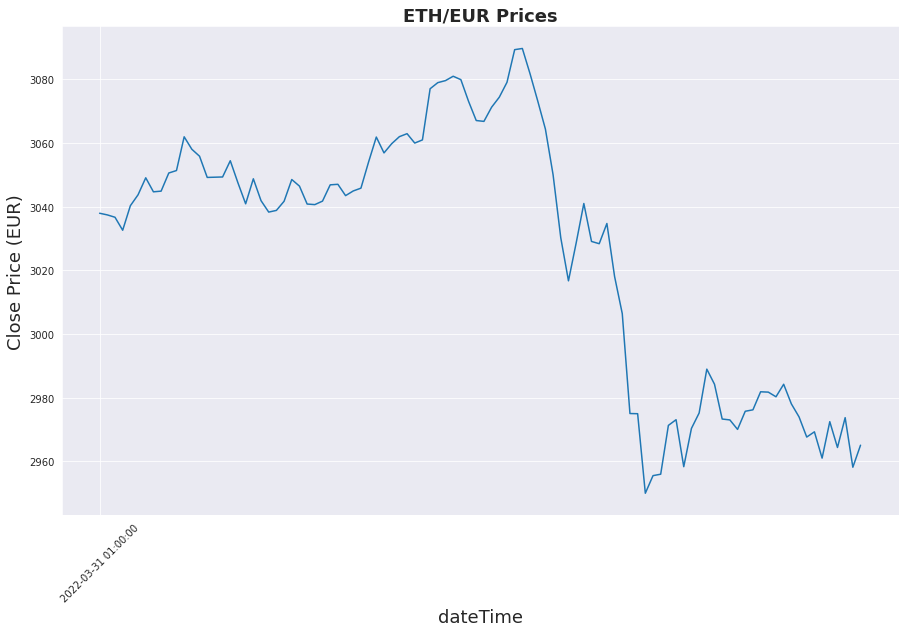

In [131]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data['close'])
tick_slice = int(max(data.index)/10)
tick_slices = np.arange(min(data.index), max(data.index)+1, tick_slice)
plt.xticks(tick_slices, data['dateTime'].loc[::tick_slice],rotation=45)
plt.title(f"{pair} Prices",fontsize=18, fontweight='bold')
plt.xlabel('dateTime',fontsize=18)
plt.ylabel('Close Price (EUR)',fontsize=18)
plt.show()

In [132]:
# transform = transforms.Compose([transforms.Resize((64,64)),
#                                 transforms.ToTensor()])

# imageFolderDataset = datasets.ImageFolder('../data/faces/training', transform=transform)
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=imageFolderDataset, transform=transform)

# train_dataset, val_dataset = train_test_split(siamese_dataset,  test_size = 0.2, shuffle=False)

# train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers = config['num_workers'], pin_memory=config['pin_memory'], shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)

In [133]:
class MyDataset(Dataset):
    def __init__(self, dataset, lookback, pred_window):
        super().__init__()
        self.dataset = dataset
        self.lookback = lookback
        self.pred_window = pred_window
        
        self.len = (len(dataset) - self.lookback - self.pred_window) + 1

    def __getitem__(self, index):
        features = []
        labels = []
        
        for i in range(index,index+self.lookback):
            features.append(self.dataset[i])
        
        for i in range(index, index+self.pred_window):
            labels.append(self.dataset[self.lookback+i])
            
        return (torch.tensor([features],dtype=torch.float32)), torch.tensor(labels,dtype=torch.float32)
    
    def __len__(self):
        return self.len

In [134]:
#creating the dataset
lookback = 10
pred_window = 1



In [144]:
#importing the libraries
import numpy as np 
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

dataset = MyDataset(dataset=list(data['close'].values),lookback=lookback,pred_window=pred_window)

train_dataset, val_dataset = train_test_split(dataset,  test_size = 0.2, shuffle=False)
val_dataset, test_dataset = train_test_split(val_dataset,  test_size = 0.5, shuffle=False)

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers = config['num_workers'], pin_memory=config['pin_memory'], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# dataiter = iter(train_dataloader)

# for index, (features, labels) in enumerate(dataiter):
#     print('features:',features.tolist())
#     print('labels:',labels)
#     break


In [145]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.h_n = None  # hidden state
        self.c_n = None  # cell state

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def init_states(self, batch_size):
        weight = next(self.parameters()).data
        
        self.h_n=weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device)
        self.c_n=weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device)
            
    def forward(self, x):
        states = (self.h_n, self.c_n)
        out, (self.h_n, self.c_n) = self.lstm(x, states)

        # get the last one of the (sequential) output from the LSTM
        out = out[:, -1, :]  # (batch, hidden_size)
        out = self.linear(out)  # (batch, 1)

        return out

In [146]:
# Model
model = LSTM(input_dim=lookback, hidden_dim=pred_window, num_layers=1, output_dim=pred_window)
model.to(device)

# Compile
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
criterion = nn.MSELoss()

In [147]:
# Train
n_epochs = 150

for epoch in range(1, n_epochs+1):

    # train
    i, train_loss, val_loss = 0, 0., 0.
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        model.init_states(batch_size=x.shape[0])

        out = model(x)
        loss = criterion(out, y.float())
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        i += 1
    train_loss /= i

    # validate
    with torch.no_grad():
        i = 0
        for x, y in val_dataloader:
            x,y = x.to(device), y.to(device)

            model.init_states(batch_size=x.shape[0])
            out = model(x)
            loss = criterion(out, y.float())
            val_loss += loss.item()
            i += 1
        val_loss /= i

    print('epoch: {} | train_loss: {:0.5f} | val_loss: {:0.5f}'.format(epoch, train_loss, val_loss))

epoch: 1 | train_loss: 9237436.00000 | val_loss: 8871837.00000
epoch: 2 | train_loss: 9237436.00000 | val_loss: 8871835.00000
epoch: 3 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 4 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 5 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 6 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 7 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 8 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 9 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 10 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 11 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 12 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 13 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 14 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 15 | train_loss: 9237435.00000 | val_loss: 8871835.00000
epoch: 16 | train_loss: 9237435.00000 | val_loss:

In [148]:
# Test
with torch.no_grad():
    for x, y in val_dataloader:
        x,y = x.to(device),y.to(device)

        model.init_states(batch_size=x.shape[0])
        out = model(x)
        
        #loss = criterion(out, y.float().view(-1, 1))
print(len(x))

9


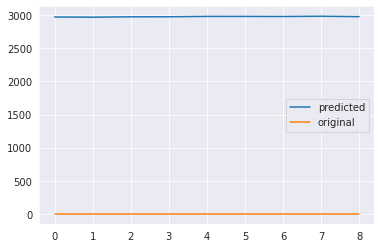

In [150]:
plt.plot(y.cpu(),label='predicted')
plt.plot(out.view(-1).cpu(),label='original')
plt.legend()